In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
import rubin_sim
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
from rubin_sim.data import get_baseline
rubin_sim.__version__
import meanz_modules as mzmod
import scipy
import sklearn

In [82]:
from os import path
opsim_fname = rubin_sim.data.get_baseline()
run_name = path.splitext(path.basename(opsim_fname))[0]
nside=64

# Acquiring a dataset

We begin by getting a dataset that is useful for exploring an "area at risk" metric.  As a reminder, the idea behind this metric is that it will assume that we are unable to fully address the depth inhomogeneities induced by rolling (in particular due to the spatial structure generating large-scale power) so we will instead apply some draconian area cuts to get a catalog that has much less large-scale power in the depth maps and other quantities that generate systematics.  We have a 3x2pt FoM metric already in MAF, and it takes a depth and area as inputs -- so as long as we can identify the potential area loss due to rolling, we can use the FoM metric for the full area vs. the horribly cut area to make a metric quantifying scientific losses.

The focus of this notebook, therefore, is on how to actually define the area that is at risk.

We'd like to begin with a case that we know is problematic, so we can ensure our metric captures it.  To that end, we start with the i-band depth map after 3 years (cumulative), as we know that in the baseline strategy that is the maximally inhomogeneous year.

We'll do this both for baseline and noroll (as a comparison).  We start with baseline; the plots below show the depth map and the 1D histogram of depth values.  Then we get the same for noroll.

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


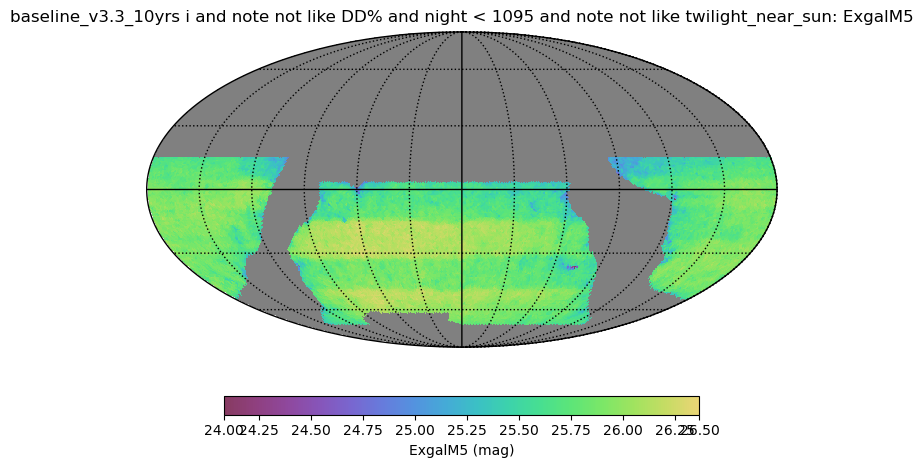

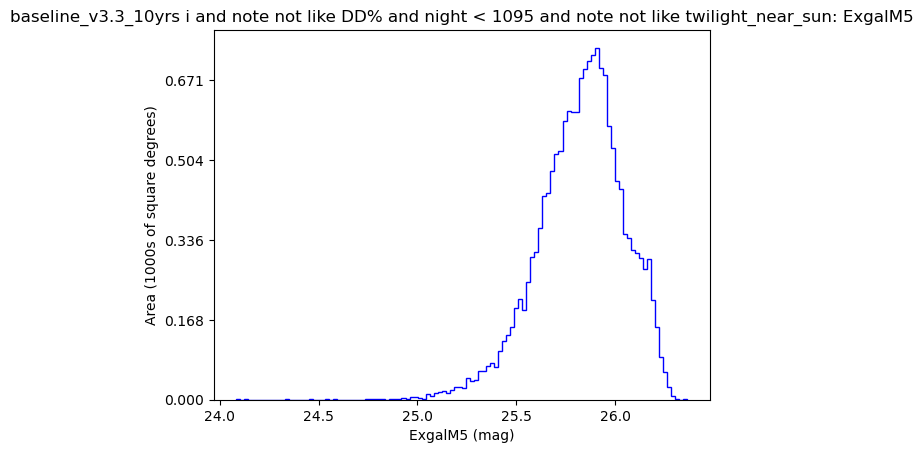

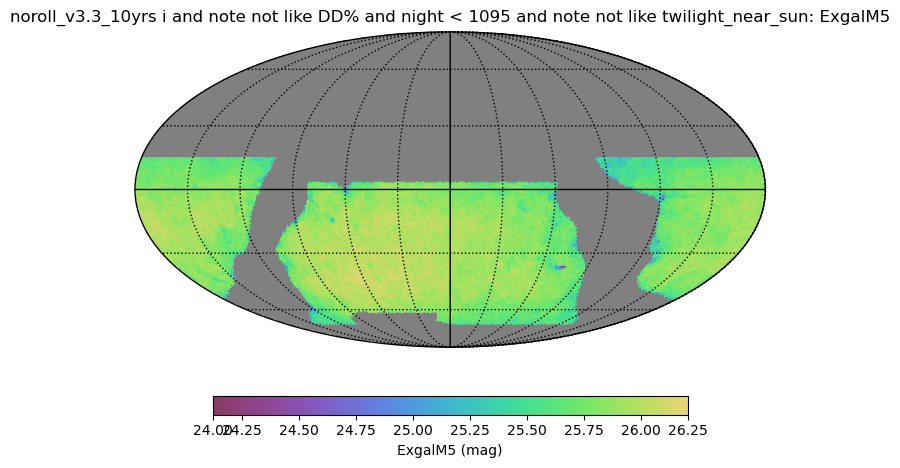

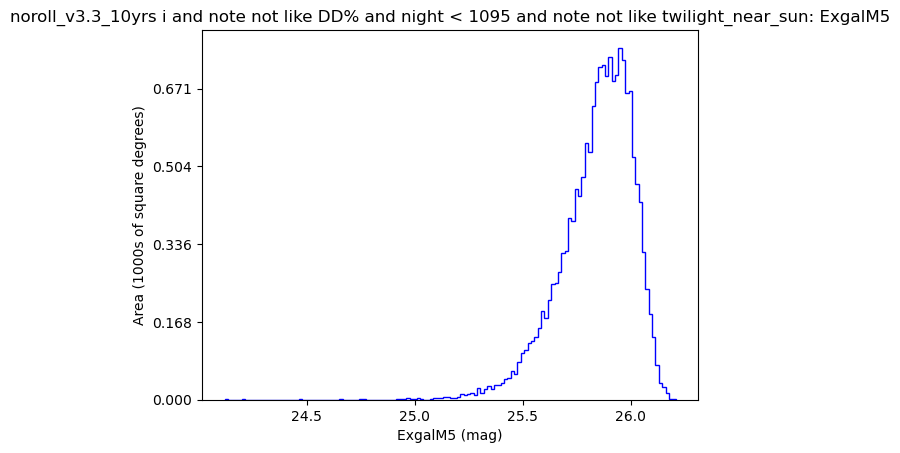

In [43]:
v33_sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
               '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db']
v33_name_list = [path.splitext(path.basename(sim))[0] for sim in v33_sim_list]
outmaps = {}

for i in range(len(v33_sim_list)):
    bgroup, bd, outmaps[v33_name_list[i]] = mzmod.metric_plots(v33_name_list[i], v33_sim_list[i], year=3, nside=nside, return_map=True)
    bgroup.plot_all(closefigs=False)

# Diagnostic plots

The above plots were separately constructed for each strategy.  We'd like a fair comparison, as that might help us move towards a way of defining "area at risk".  Let's begin with the 1D PDF of i-band depth values, using a common set of bins.

Text(0.5, 0, 'i-band limiting magnitude')

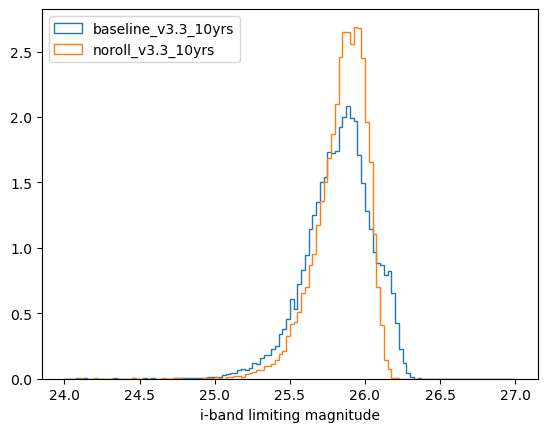

In [124]:
# Define a set of histogram bins
min_depth = 24.0
max_depth = 27.0
delta_depth = 0.025
n_bins = (max_depth-min_depth)/delta_depth
bins = np.linspace(min_depth, max_depth, int(n_bins+1))
# Define plot
fig = plt.figure()
ax = fig.add_subplot(111)
for key in outmaps.keys():
    # Get non-masked (nonzero) pixel values
    this_map = outmaps[key]
    # Make and plot histogram
    plt.hist(this_map[this_map>0.1], bins=bins, label=key, density=True, histtype='step')
plt.legend()
plt.xlabel('i-band limiting magnitude')

We see that the `noroll` case is more narrowly peaked as expected.  There is a tail to shallower values for baseline, along with a funny "shoulder" on the faint end.

While this was instructive, it would be interesting to more precisely pinpoint what rolling is doing by considering the differences _at fixed position on the sky_ -- i.e., the PDF of the _difference_ in depths.  Let's do that next, and try to model it as a sum of two Gaussians (one to model a shift towards brighter values, one to model a shift towards fainter values).

In [45]:
def double_gauss(x, *args):
    # Convenience function for fitting to a sum of Gaussians.
    m1, m2, s1, s2, k1, k2 = args
    ret = k1*scipy.stats.norm.pdf(x, loc=m1 ,scale=s1)
    ret += k2*scipy.stats.norm.pdf(x, loc=m2 ,scale=s2)
    return ret
params = [-0.2, 0.2, 0.1, 0.1, 1, 1]

Best-fitting parameters: [-0.14964124  0.08860888  0.08368118  0.08332825  0.44246226  0.57513155]


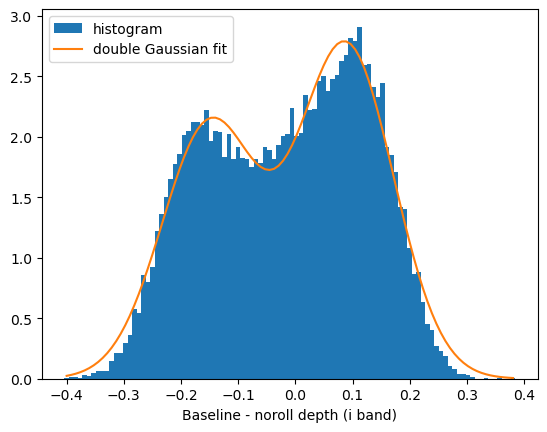

In [125]:
# Take the difference between maps
map1 = outmaps['baseline_v3.3_10yrs']
map2 = outmaps['noroll_v3.3_10yrs']
dmap = map1 - map2

# Mask differently, since 0 is now a reasonable value
dmap[map1<0.1] = -100
dmap[map2<0.1] = -100

# Histogram the differences
fig = plt.figure()
ax = fig.add_subplot(111)
counts, bins, _ = plt.hist(dmap[dmap>-99], density=True, bins=100, label='histogram')
bin_mids = 0.5*(bins[1:] + bins[:-1])
plt.xlabel('Baseline - noroll depth (i band)')

# Fitting
fitted_params,_ = scipy.optimize.curve_fit(double_gauss, bin_mids, counts, p0=params)
plt.plot(bin_mids, double_gauss(bin_mids, *fitted_params), label='double Gaussian fit')
plt.legend()

print('Best-fitting parameters:',fitted_params)

We can see that this distribution is relatively broad and double-peaked, so it can be pretty well fit by a double Gaussian.

This suggests one possible pathway to defining an "area at risk" metric: cut this distribution at the local minimum in between the peaks, and keep the larger chunk of pixels.  While they won't be exactly continguous, they will be approximately contiguous (we can of course check this directly), and it's just to give us an approximate idea anyway.

To confirm this idea, we can read off the local minimum as falling at -0.05.  Below is the overall depth map, followed by a version containing only those regions with Delta(depth)>-0.05.  As shown, the regions selected are relatively contiguous.


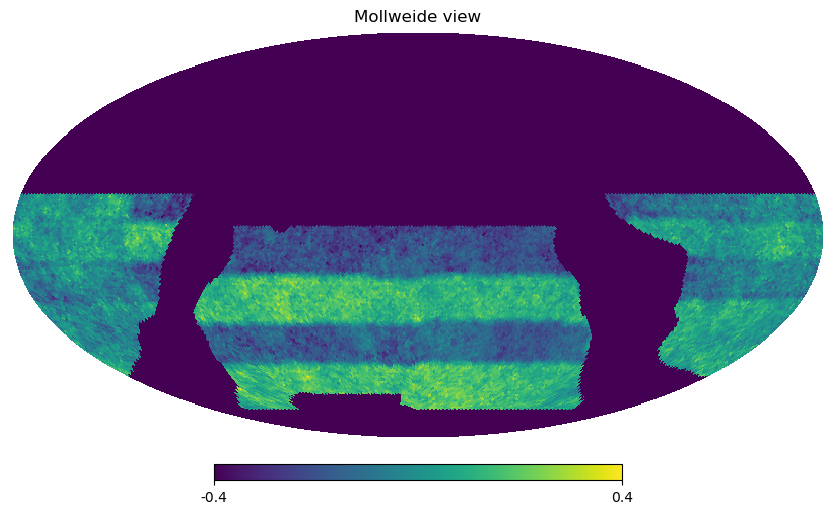

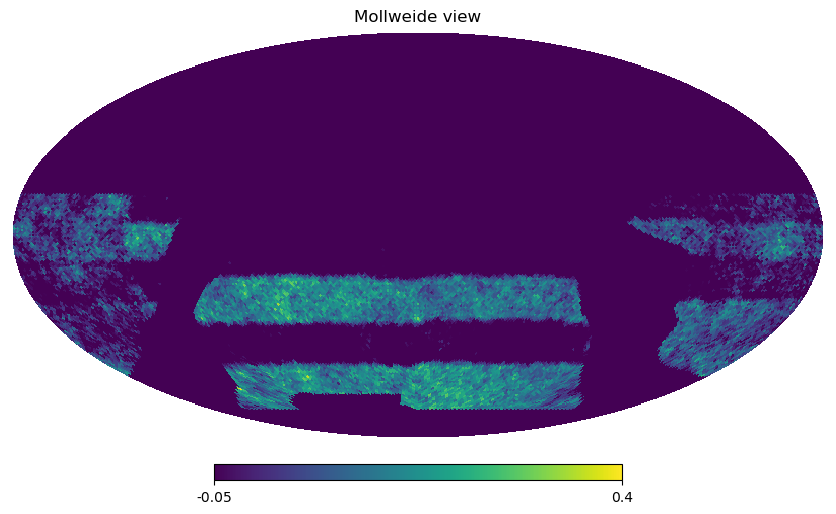

In [131]:
hp.visufunc.mollview(dmap, min=-0.4, max=0.4)
hp.visufunc.mollview(dmap, min=-0.05, max=0.4)

TODO: We can also compute the total power metric to confirm that we've reduced the large-scale power with this selection.  That will be important in discussions with the SCOC: when the total distribution of depth across the survey is already ~0.5 mag wide in the `noroll` case, it's hard to argue that another few tenths of a mag is a problem.  So we have to argue on the basis that it's non-random and leads to significant large-scale power that will affect lensing/clustering measurements.

The disadvantage of this approach to defining an "area at risk" metric is that the metric will require information about multiple strategies in order to be run -- i.e., it requires information about a comparable strategy without rolling to define the area to be cut.  While we have generally been OK with our metrics being relative in their outputs (e.g., that we compare the output from baseline to the output from noroll), it could introduce significant technical complexity to require one strategy as an _input_ to computing the metric for another.  For this reason we would like to explore other options.

# Unsupervised clustering

Boris pointed out that the structure in the depth maps due to rolling should be easy for an unsupervised clustering algorithm to identify, and that could be another pathway to an "area at risk" metric.  The nice thing about this is that it could potentially address the disadvantage of the previous approach we considered, by allowing us to identify the areas to include/exclude based on inspection of a strategy on its own.

Below are a number of utility routines that take depth maps, construct a suitable dataset for clustering (we have to rescale RA/dec to avoid their variation dominating over the depth variations, and apply masks), run an unsupervised clustering algorithm, and then inspect the results at the map level.

In [147]:
def make_clustering_dataset(depth_map, maskval=0, priority_fac=0.9, nside=64):
    # A utility routine to get a dataset for unsupervised clustering.  Note:
    # - We want the unmasked regions of the depth map only.
    # - We assume masked regions are set to `maskval`, and cut 0.1 magnitudes above that.
    # - We really want it to look at depth fluctuations.  So, we have to rescale the 
    #   RA/dec dimensions to avoid them being prioritized because their values are larger and
    #   have more variation than depth.  Currently we rescale RA/dec such that their 
    #   standard deviations are 1-priority_fac times the standard deviation of the depth map.
    #   That's why priority_fac is a tunable parameter; it should be between 0 and 1
    if priority_fac<0 or priority_fac>=1:
        raise ValueError("priority_fac must lie between 0 and 1")
    theta, phi = hp.pixelfunc.pix2ang(nside, ipix=np.arange(hp.nside2npix(nside)))
    # theta is 0 at the north pole, pi/2 at equator, pi at south pole; phi maps to RA
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    
    # Make a 3D numpy array containing the unmasked regions, including a rescaling factor to prioritize the depth
    n_unmasked = len(depth_map[depth_map>0.1])
    my_data = np.zeros((n_unmasked, 3))
    cutval = 0.1 + maskval
    my_data[:,0] = ra[depth_map>cutval]*(1-priority_fac)*np.std(depth_map[depth_map>cutval])/np.std(ra[depth_map>cutval])
    my_data[:,1] = dec[depth_map>cutval]*(1-priority_fac)*np.std(depth_map[depth_map>cutval])/np.std(dec[depth_map>cutval])
    my_data[:,2] = depth_map[depth_map>cutval]
    return my_data

In [148]:
def apply_clustering(clustering_data):
    # A thin wrapper around sklearn routines (can swap out which one we are using systematically).
    # We fix parameters like `n_clusters` since realistically we know for rolling that we should expect 2 clusters.
    from sklearn.cluster import SpectralClustering
    clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(clustering_data)
    labels = clustering.labels_ + 1
    return labels

In [149]:
def expand_labels(depth_map, labels, maskval=0):
    # A utility to apply the labels from a masked version of a depth map back to the entire depth map.
    expanded_labels = np.zeros(hp.nside2npix(nside))
    cutval = maskval+0.1
    expanded_labels[depth_map>cutval] = labels
    return expanded_labels

In [154]:
def show_clusters(depth_map, labels, maskval=0, n_clusters=2, min=24.5, max=26.5):
    # A routine to show the clusters found by the unsupervised clustering algorithm.
    expanded_labels = expand_labels(depth_map, labels, maskval=maskval)
    hp.visufunc.mollview(depth_map, min=min, max=max)
    cutval = maskval+0.1
    for i in range(n_clusters):
        new_map = depth_map.copy()
        new_map[expanded_labels!=i+1] = maskval
        hp.visufunc.mollview(new_map, min=min, max=max)
        print('Fraction of area in cluster %d: %f'%(i+1,len(new_map[new_map>cutval])/len(depth_map[depth_map>cutval])))
        print('Median value for cluster %d: %f'%(i+1,np.median(new_map[new_map>cutval])))

We'd like to use these utility routines to make a clustering-ready dataset out of the baseline_v3.3 depth map at year 3, unmasked regions only.  Then do the clustering and examine the results.

Note that we're telling it there are two clusters.  The `show_clusters` step is going to produce 3 maps:
1. The original depth map for the strategy.
2. The depth map for cluster 1.
3. The depth map for cluster 2.

It will also report on the fraction of area in each cluster.

In [151]:
clustering_data = make_clustering_dataset(map1)
labels = apply_clustering(clustering_data)

Fraction of area in cluster 1: 0.424001
Median value for cluster 1: 25.664144
Fraction of area in cluster 2: 0.575999
Median value for cluster 2: 25.949281


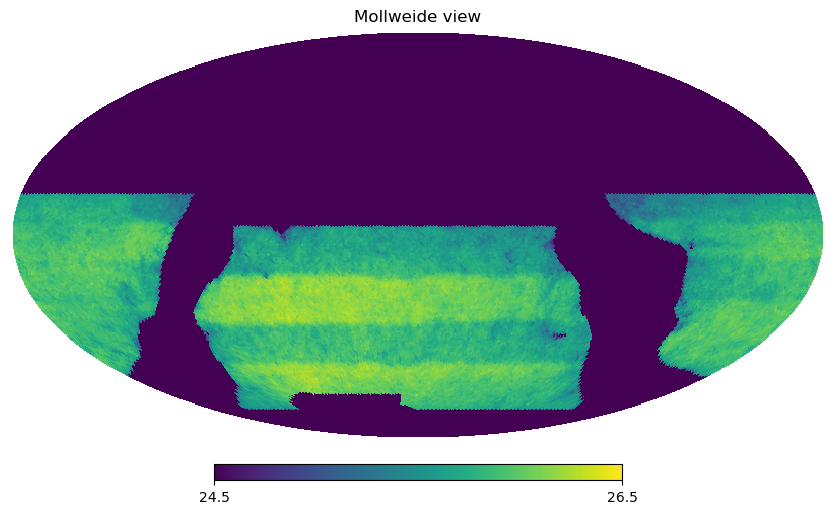

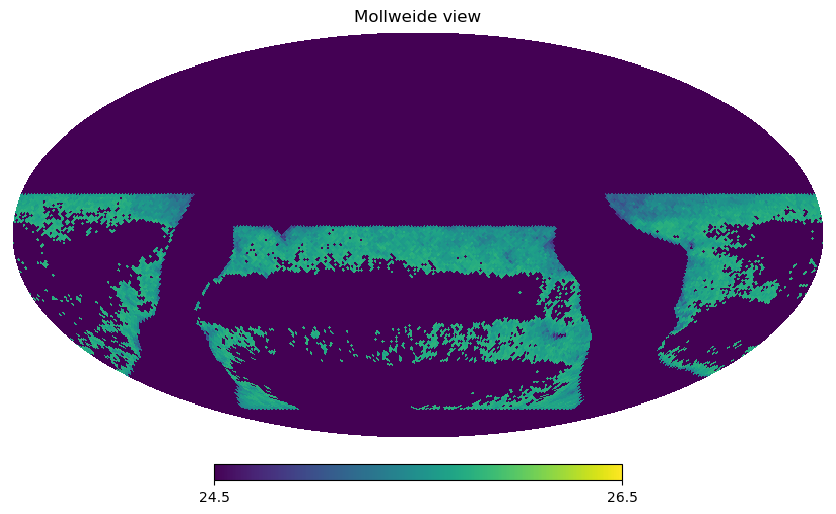

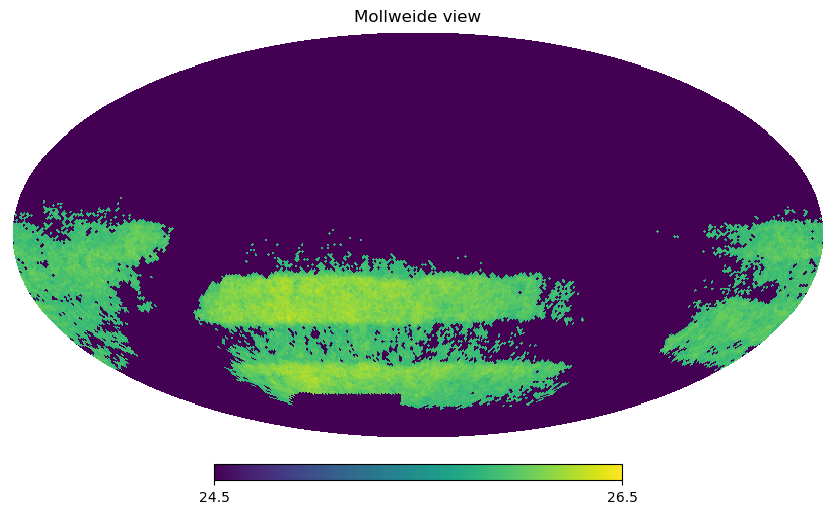

In [155]:
show_clusters(map1, labels)

While these clusters aren't exactly what we want (there are a few places where it doesn't recognize interleaved stripes), it seems like a promising starting point for further tuning.

Since the areas are 42% and 58%, presumably we would identify the larger region as the one we'd keep.  The two regions have different median depths by ~0.3 magnitudes.

TODO: check total power metric for these clusters to confirm significant reduction in power compared to the overall depth map.

We also want to get sensible results if we run the metric on datasets that don't show as much structure as baseline at year 3.  In particular, we'd like it to recognize relatively homogeneous datasets (at the level of `noroll`) by putting most of the dataset into one cluster and noting that the medians are not that different.

Fraction of area in cluster 1: 0.641238
Median value for cluster 1: 25.935378
Fraction of area in cluster 2: 0.358762
Median value for cluster 2: 25.697828


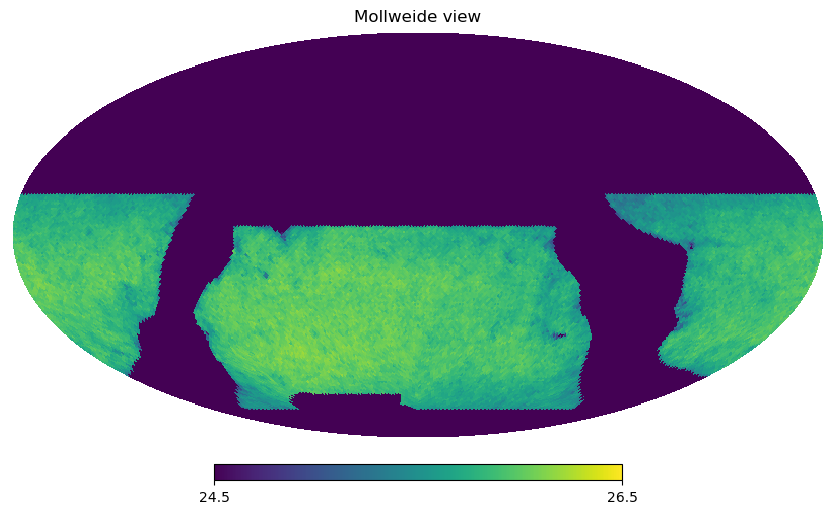

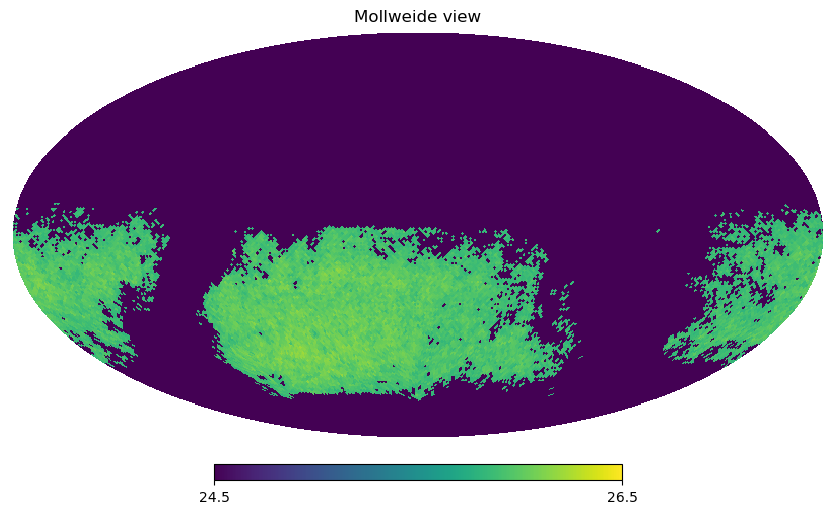

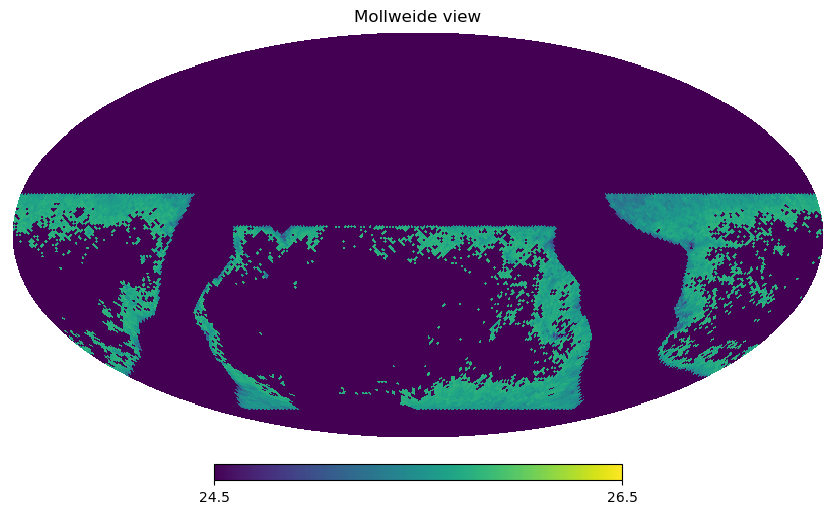

In [156]:
# Let's see what happens when we try this with noroll -- does it recognize there isn't as much structure?
clustering_data = make_clustering_dataset(map2)
labels = apply_clustering(clustering_data)
show_clusters(map2, labels)

It still has two relatively large regions with notably different depths.  However, here the difference is mainly "central to survey" versus "edge".  It feels like there should be some automated way to note this and conclude that no area loss is warranted?